# **Prédiction du salaire selon le poste**


Nom et prenom : Mohamed Taleb

Matricule : C25421




##  Objectif du projet

Développer un modèle de **regréssion** capable de **prédire le salaire** en fonction de l’intitulé du poste, à partir d’un jeu de données obtenu sur **Kaggle**.

---

##  Description des données

Le jeu de données contient notamment les colonnes suivantes :
- **Age** : Age de l'employeur
- **Genre** : Sexe de l'employeur
- **Niveau d'éducation** : Niveau d'éducation de l'employeur
- **Titre d'emploi** : Role de l'employeur
- **Année d'expérience** : Expérience de l'employeur
- **Salaire** : Salaire mensuel

---

##  Méthodologie
1. Chargement et exploration des données
2. Nettoyage et vectorisation des intitulés de poste
3. Entraînement d’un modèle de régression
4. Évaluation des performances
5. Recommandations ou améliorations possibles


## 1. Chargement et exploration des données

In [35]:
# Importation de la bibliothèque pandas pour la manipulation des données
import pandas as pd

# Chargement du fichier CSV contenant les données de salaires
df = pd.read_csv("Salary_Data.csv")

# Affichage des 5 premières lignes du jeu de données pour avoir un aperçu
df.head()


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [6]:
# Affichage du type de données de chaque colonne (object, float, int, etc.)
df.dtypes


Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object

In [7]:
# Affichage des statistiques descriptives (moyenne, min, max, etc.)
df.describe()


,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [8]:
# Affichage du nombre de valeurs manquantes par colonne
df.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [9]:
# Calcul du pourcentage de valeurs manquantes par colonne
(df.isnull().sum() / len(df)) * 100

Age                    0.029833
Gender                 0.029833
Education Level        0.044749
Job Title              0.029833
Years of Experience    0.044749
Salary                 0.074582
dtype: float64

## 2. Nettoyage et vectorisation des intitulés de poste

###  Traitement des valeurs manquantes 

Dans notre jeu de données, certaines observations comportaient des valeurs manquantes dans différentes colonnes, avec un taux global relativement faible (moins de 8%). Plutôt que de supprimer l’ensemble de ces lignes, nous avons opté pour une stratégie d’imputation raisonnée, afin de préserver un maximum d’information utile pour l’apprentissage du modèle.

- Les observations sans valeur de **salaire** (`Salary`) ont été supprimées, cette variable étant la **cible à prédire**. Son imputation aurait entraîné un biais significatif dans la modélisation.
- Les variables numériques telles que **l’âge** et **les années d’expérience** ont été complétées par la **médiane**, une mesure robuste qui limite l’influence des valeurs extrêmes.
- Pour les variables qualitatives comme **le genre** et **le niveau d’éducation**, nous avons utilisé la **valeur la plus fréquente** (mode), méthode simple et couramment utilisée dans ce type de données.
- Enfin, les intitulés de poste (`Job Title`) manquants ont été remplacés par la valeur `"Unknown"`, afin de permettre leur traitement lors de l’étape de vectorisation.

Cette approche nous a permis de conserver une base de données cohérente, sans perte d’information excessive, tout en maintenant la rigueur nécessaire pour l’entraînement d’un modèle de régression fiable.


In [12]:
import numpy as np

In [18]:
# 1. Supprimer les lignes où le salaire est manquant
df_cleaned = df[~df['Salary'].isnull()].copy()

In [19]:
# 2. Imputation numérique (par médiane)
df_cleaned['Age'] = df_cleaned['Age'].fillna(df_cleaned['Age'].median())
df_cleaned['Years of Experience'] = df_cleaned['Years of Experience'].fillna(df_cleaned['Years of Experience'].median())

In [20]:
# 3. Imputation catégorielle (par valeur la plus fréquente)
df_cleaned['Gender'] = df_cleaned['Gender'].fillna(df_cleaned['Gender'].mode()[0])
df_cleaned['Education Level'] = df_cleaned['Education Level'].fillna(df_cleaned['Education Level'].mode()[0])

In [21]:
# 4. Remplacer Job Title manquant par "Unknown"
df_cleaned['Job Title'] = df_cleaned['Job Title'].fillna("Unknown")

In [22]:
df_cleaned.isnull().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

###  Encodage et vectorisation 

La variable **Job Title**, qui contient des intitulés de poste sous forme textuelle, ne peut pas être utilisée directement dans un modèle de régression. Il est donc nécessaire de la transformer en une représentation numérique exploitable par les algorithmes de machine learning. Pour cela, nous avons utilisé la méthode **TF-IDF (Term Frequency - Inverse Document Frequency)**.

Cette méthode permet de convertir chaque intitulé de poste en un vecteur numérique en tenant compte de l'importance de chaque mot dans le contexte global du corpus. Le principe est de pondérer chaque terme selon sa fréquence dans le document (intitulé de poste) et son caractère informatif (sa rareté dans l’ensemble des documents). Ainsi, les mots fréquents mais peu discriminants sont atténués, tandis que les mots plus spécifiques à un poste sont valorisés.

Nous avons limité la vectorisation aux **100 mots les plus importants** (**max_features=100**) afin de réduire la dimensionnalité et faciliter l’entraînement du modèle. Chaque poste est ainsi représenté par un vecteur de 100 valeurs numériques, prêt à être utilisé dans notre modèle de régression.


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialisation du vecteur TF-IDF 
vectorizer = TfidfVectorizer(max_features=100)

# Transformation de la colonne 'Job Title'
X_job = vectorizer.fit_transform(df_cleaned['Job Title'])

# Conversion en tableau numpy
X_job_array = X_job.toarray()

# Affichage de la forme de la matrice vectorisée
print("Dimensions de la matrice TF-IDF :", X_job_array.shape)


Dimensions de la matrice TF-IDF : (6699, 96)


## 3. Entraînement d’un modèle de régression

### Modélisation : Choix de deux modèles de régression

Afin d’identifier le modèle le plus adapté à notre jeu de données, nous avons décidé de tester deux approches de régression :

- Une **régression linéaire simple**, qui établit une relation directe entre les variables explicatives (vecteurs issus des intitulés de poste) et la variable cible (salaire).
- Une **régression Ridge**, qui reprend le principe de la régression linéaire mais avec une **régularisation L2**, permettant de limiter les effets des coefficients extrêmes et de mieux gérer la multicolinéarité éventuelle entre les variables.

Après l'entraînement de chaque modèle, nous interpréterons les résultats à l’aide de métriques d’évaluation standards (MAE, RMSE, R²) afin de comparer leur performance.


### 3.1 Bibliothèques utilisées pour la modélisation (Régression linéaire)

Avant d'entraîner notre modèle de régression, nous avons importé les bibliothèques nécessaires :

- `from sklearn.linear_model import LinearRegression`  
  → Permet d'utiliser le modèle de **régression linéaire** fourni par la bibliothèque **scikit-learn**, qui sert à établir une relation linéaire entre les variables explicatives (ici, les vecteurs issus des intitulés de poste) et la variable cible (le salaire).

- `from sklearn.model_selection import train_test_split`  
  → Fonction utilisée pour **diviser les données en deux sous-ensembles** : un pour l'entraînement (80% dans notre cas) et un pour le test(20% dans notre cas). Cela permet d’évaluer la capacité du modèle à généraliser sur des données nouvelles.


Ces outils sont essentiels pour mettre en place et entraîner un modèle de régression fiable dans un projet de machine learning.


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [26]:
# Définition de la variable cible
y = df_cleaned['Salary'].values

In [27]:
# Séparation en jeu d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_job_array, y, test_size=0.2, random_state=42)


In [28]:
# Initialisation du modèle de régression linéaire
model = LinearRegression()

In [29]:
# Entraînement du modèle sur le jeu d'entraînement
model.fit(X_train, y_train)

LinearRegression()

In [30]:
# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

### 3.1.1 Evaluation du modèle (Régression linéaire)

###  Évaluation du modèle

Après l'entraînement du modèle de régression linéaire, nous avons procédé à son évaluation à l’aide de plusieurs métriques standards. Ces mesures permettent de quantifier l’écart entre les salaires prédits par le modèle et les salaires réels observés dans le jeu de test.

- `from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score`  
  → Ces fonctions servent à **évaluer la qualité du modèle**.

  
Les indicateurs utilisés sont :

- **MAE (Mean Absolute Error)** : calcule la moyenne des erreurs absolues entre les prédictions et les vraies valeurs. Une faible MAE signifie que le modèle se trompe peu en moyenne.
- **RMSE (Root Mean Squared Error)** : racine de l’erreur quadratique moyenne, qui pénalise davantage les grandes erreurs. C’est une mesure sensible aux valeurs extrêmes.
- **R² (coefficient de détermination)** : mesure la proportion de la variance expliquée par le modèle. Une valeur proche de 1 indique une bonne capacité prédictive.

- `import numpy as np`  
  → Bibliothèque pour le calcul scientifique. Ici, elle est utilisée pour calculer la **racine carrée du MSE** afin d’obtenir le **RMSE** via `np.sqrt(...)`.

Ces métriques nous permettent de juger objectivement la performance du modèle sur des données nouvelles, non vues pendant l'entraînement.


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [36]:
# Affichage formaté des résultats
print(" Évaluation du modèle :")
print(f"MAE (Erreur absolue moyenne)        : {mae:.2f}")
print(f"RMSE (Erreur quadratique moyenne)   : {rmse:.2f}")
print(f"R² (Coefficient de détermination)   : {r2:.3f}")

 Évaluation du modèle :
MAE (Erreur absolue moyenne)        : 191151831215979.81
RMSE (Erreur quadratique moyenne)   : 5366725134756368.00
R² (Coefficient de détermination)   : -10130904158927365079040.000


## 3.1.2 Interprétation des résultats — Régression linéaire simple

Les résultats obtenus avec la régression linéaire simple se sont révélés très insatisfaisants. Les erreurs d’estimation (MAE et RMSE) étaient extrêmement élevées, atteignant des valeurs irréalistes, et le coefficient de détermination `R²` était fortement négatif.

Un tel score indique que le modèle est **incapable d’expliquer la variance du salaire**, et qu’il **prédit moins bien qu’un modèle naïf** qui utiliserait simplement la moyenne.

## 3.2 Bibliothèques utilisées pour la modélisation (Régression Ridge)

Nous utilisons ici un modèle de **régression Ridge**, une version régularisée de la régression linéaire, qui ajoute une pénalité (de type L2) sur la taille des coefficients. Cette méthode permet de **réduire le surapprentissage** et d’améliorer la **stabilité numérique** du modèle, surtout dans des cas de forte colinéarité ou de vecteurs très dispersés comme ceux issus du TF-IDF.

Voici les éléments du code :

- `from sklearn.linear_model import Ridge` : importation de la classe Ridge fournie par la bibliothèque scikit-learn.
- `ridge_model = Ridge(alpha=1.0)` : création du modèle avec un paramètre de régularisation `alpha = 1.0`, qui contrôle l’intensité de la pénalité.
- `ridge_model.fit(X_train, y_train)` : entraînement du modèle sur les données d’entraînement.
- `ridge_model.predict(X_test)` : prédiction des salaires sur le jeu de test.
- Enfin, les métriques **MAE**, **RMSE** et **R²** sont recalculées pour évaluer les performances du modèle.

Cette approche vise à obtenir une meilleure généralisation et des prédictions plus fiables.


In [38]:
# Importation du modèle Ridge (régression linéaire avec régularisation L2)
from sklearn.linear_model import Ridge

In [39]:
#  Création du modèle avec un coefficient de régularisation alpha
ridge_model = Ridge(alpha=1.0)

In [40]:
# Entraînement du modèle sur le jeu d'entraînement
ridge_model.fit(X_train, y_train)

Ridge()

In [41]:
#  Prédiction sur les données de test
y_pred_ridge = ridge_model.predict(X_test)

In [43]:
# Évaluation du modèle Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

In [44]:
#  Affichage des résultats
print("📊 Évaluation du modèle Ridge :")
print(f"MAE (Erreur absolue moyenne)        : {mae_ridge:.2f}")
print(f"RMSE (Erreur quadratique moyenne)   : {rmse_ridge:.2f}")
print(f"R² (Coefficient de détermination)   : {r2_ridge:.3f}")

📊 Évaluation du modèle Ridge :
MAE (Erreur absolue moyenne)        : 25382.53
RMSE (Erreur quadratique moyenne)   : 32628.47
R² (Coefficient de détermination)   : 0.626


### Interprétation des résultats — Régression Ridge

Les résultats obtenus avec le modèle de régression Ridge sont nettement plus satisfaisants que ceux de la régression linéaire simple. Le modèle affiche un **MAE d’environ 25 000**, un **RMSE de près de 32 600**, et un **coefficient de détermination `R²` de 0.626**, ce qui signifie qu’il explique **environ 63% de la variance du salaire**.

Cette amélioration est principalement due à l’effet de la **régularisation L2** introduite par Ridge, qui permet de contrôler les coefficients extrêmes et d’éviter le surapprentissage causé par les dimensions élevées générées par le TF-IDF. En d’autres termes, Ridge parvient à capter des relations pertinentes entre les intitulés de poste et les salaires, tout en conservant une certaine stabilité.

Nous retenons donc la **régression Ridge comme le modèle le mieux adapté** à ce jeu de données, dans la mesure où elle offre des prédictions plus fiables et une généralisation plus robuste par rapport à la régression linéaire simple.


#### Visualisation : Prédictions vs Réalité (Ridge)


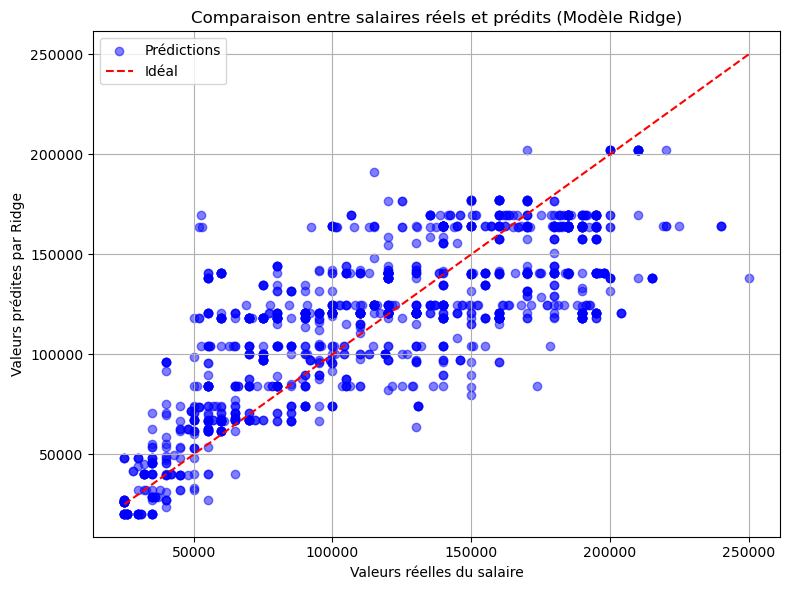

In [46]:
import matplotlib.pyplot as plt

# Création du graphique comparatif : salaires réels vs prédits
plt.figure(figsize=(8, 6))

# Nuage de points : prédictions vs valeurs réelles
plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='blue', label='Prédictions')

# Ligne idéale : où y_pred = y_test
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Idéal')

# Étiquettes et titre
plt.xlabel("Valeurs réelles du salaire")
plt.ylabel("Valeurs prédites par Ridge")
plt.title("Comparaison entre salaires réels et prédits (Modèle Ridge)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Affichage du graphique
plt.show()

Le graphique ci-dessus compare les **valeurs réelles** des salaires (axe horizontal) aux **valeurs prédites** par le modèle de régression Ridge (axe vertical). Chaque point bleu représente une observation du jeu de test.

La **ligne rouge en pointillés** correspond à une prédiction parfaite (où le salaire prédit est exactement égal au salaire réel).  
Plus les points sont **proches de cette ligne**, plus le modèle est précis.

Globalement, on observe une **tendance linéaire correcte**, avec la majorité des points regroupés autour de la diagonale, ce qui indique que le modèle **parvient à capturer la relation entre l’intitulé de poste et le salaire**.  
Cependant, on remarque quelques écarts plus marqués, notamment aux extrémités, ce qui est normal dans une tâche de régression à partir de texte, car certains intitulés rares ou ambigus sont plus difficiles à prédire.

Cela confirme que la **régression Ridge offre une bonne capacité de généralisation**, avec une performance cohérente visuellement et numériquement.


##  Interface interactive avec Gradio

Pour rendre notre modèle plus accessible, nous avons développé une interface simple avec **Gradio**.  
Cette interface permet à l'utilisateur de saisir un intitulé de poste, et d'obtenir en retour une prédiction du salaire estimé selon le modèle Ridge entraîné.


In [48]:
!pip install gradio

   ---------------------------------------- 0.0/54.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/54.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/54.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/54.1 MB 1.1 MB/s eta 0:00:49
    --------------------------------------- 0.8/54.1 MB 1.2 MB/s eta 0:00:47
    --------------------------------------- 1.0/54.1 MB 1.2 MB/s eta 0:00:45
    --------------------------------------- 1.3/54.1 MB 1.2 MB/s eta 0:00:45
   - -------------------------------------- 1.6/54.1 MB 1.2 MB/s eta 0:00:46
   - -------------------------------------- 1.8/54.1 MB 1.2 MB/s eta 0:00:45
   - -------------------------------------- 2.1/54.1 MB 1.2 MB/s eta 0:00:45
   - -------------------------------------- 2.4/54.1 MB 1.2 MB/s eta 0:00:44
   - -------------------------------------- 2.6/54.1 MB 1.2 MB/s eta 0:00:44
   - -------------------------------------- 2.6/54.1 MB 1.2 MB/s eta 0:00:44
   -- --------------

In [3]:
import gradio as gr

# Fonction de prédiction basée sur un intitulé de poste
def predict_salary(job_title):
    # Transformation de l'intitulé avec le vectorizer déjà entraîné
    vecteur = vectorizer.transform([job_title])
    # Prédiction du salaire avec le modèle Ridge
    prediction = ridge_model.predict(vecteur)[0]
    return f"{prediction:,.2f} $"

# Création de l’interface Gradio
interface = gr.Interface(
    fn=predict_salary,
    inputs=gr.Textbox(label="Entrez un intitulé de poste"),
    outputs=gr.Textbox(label="Salaire estimé"),
    title="💼 Prédiction de Salaire selon le Poste",
    description="Ce modèle estime le salaire à partir de l’intitulé de poste, en se basant sur un modèle de régression Ridge entraîné sur des données réelles."
)

In [4]:
# Lancement de l’interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


##                            Conclusion générale du projet

Ce projet avait pour objectif de développer un modèle de machine learning capable de **prédire le salaire** en fonction de l’**intitulé du poste occupé**, en utilisant un jeu de données réaliste issu de la plateforme Kaggle.

Nous avons commencé par une **exploration approfondie des données**, suivie d’un **nettoyage rigoureux**, en traitant les valeurs manquantes par des méthodes adaptées à chaque type de variable. L’intitulé de poste, étant une variable textuelle, a été transformé grâce à la **vectorisation TF-IDF**, permettant de représenter chaque intitulé sous forme numérique, tout en capturant l’importance relative de chaque mot dans le corpus global.

Pour la modélisation, nous avons comparé deux approches :
- La **régression linéaire simple**, qui s’est révélée instable et peu performante
- La **régression Ridge**, qui introduit une régularisation et a permis d’obtenir des résultats plus robustes

La **régression Ridge** s’est montrée la plus efficace, avec un **coefficient de détermination `R²` d’environ 0.626**, traduisant une capacité du modèle à expliquer plus de 60 % de la variance des salaires. Les erreurs moyennes (MAE ≈ 25 000) restent acceptables compte tenu de la complexité du langage naturel et de la nature simplifiée des données (le modèle ne tient compte que de l’intitulé du poste, sans expérience, localisation ou secteur d’activité).

Enfin, nous avons enrichi ce projet par la création d’une **interface interactive Gradio**, permettant à tout utilisateur de saisir un poste et d’obtenir instantanément une estimation de salaire. Cela rend le modèle non seulement performant, mais également accessible et démontrable dans un contexte réel ou pédagogique.

Ce travail illustre l’importance du **prétraitement textuel**, de la **sélection des modèles** et de la **régularisation** dans la construction d’outils prédictifs fiables à partir de données textuelles.
